## CNN Model to train a fruit image set

In [4]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import pickle
import sys   
import numpy as np
import matplotlib.pyplot as plt
from resizeimage import resizeimage
import glob
from PIL import Image as im
import cv2
# from tensorflow.examples.tutorials.mnist import input_data

## Load input data from the pickle file

In [2]:
with (open("Training_feature.pickle",'rb')) as openfile:
    while True:
        try:
            input_data=pickle.load(openfile,encoding='latin1')
        except EOFError:
            break

(808, 2500)


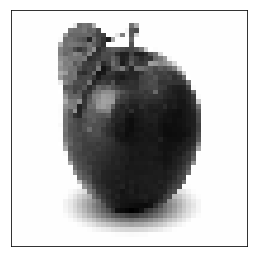

In [3]:
print(input_data[0].shape)
images=input_data[0]
newimage=np.reshape(images,(-1,50,50))
newimage[0].shape

fig = plt.figure(figsize=(50, 20))
for i in range(1):
    ax=fig.add_subplot(4, 5, i+1)
    plt.imshow(newimage[0], interpolation='nearest',cmap=plt.get_cmap('gray'))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)   
plt.show()

In [24]:
input_data[0].shape


(808, 2500)

#### Initialize the place holders and variables

In [4]:
tf.reset_default_graph()
n_classes = 3
batch_size = 128

x = tf.placeholder('float', [None, 2500])
y = tf.placeholder('float')

# keep_rate = 0.8
keep_prob = tf.placeholder(tf.float32)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def maxpool2d(x):
    #                        size of window         movement of window
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

## Defien the network [Two conv layers + One FC layer+One output layer]

In [5]:
def convolutional_neural_network(x):
    weights = {'W_conv1':tf.Variable(tf.random_normal([5,5,1,32])),
               'W_conv2':tf.Variable(tf.random_normal([5,5,32,64])),
               'W_fc':tf.Variable(tf.random_normal([13*13*64,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    x = tf.reshape(x, shape=[-1, 50, 50,1])
    
    with tf.name_scope('conv1'):
        conv1 = tf.nn.relu(conv2d(x, weights['W_conv1']) + biases['b_conv1'])
        conv1 = maxpool2d(conv1)
    
    with tf.name_scope('conv2'):
        conv2 = tf.nn.relu(conv2d(conv1, weights['W_conv2']) + biases['b_conv2'])
        conv2 = maxpool2d(conv2)
      
    with tf.name_scope('Fully_connected'):
        fc = tf.reshape(conv2,[-1, 13*13*64])
        fully_connected = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
        fc = tf.nn.dropout(fully_connected,keep_prob)
    with tf.name_scope('Fully_connected'):
        output = tf.matmul(fc, weights['out'])+biases['out']
    

    return output,conv1,conv2,weights,fc



## Train the network and save the (graph , trained weight)  using tf.train.saver

In [6]:
prediction,conv1,conv2,weights,fc = convolutional_neural_network(x)
cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y) )
tf.summary.scalar('loss',cost)
optimizer = tf.train.AdamOptimizer().minimize(cost)
with tf.name_scope('accuracy'):
    error_prediction=tf.equal(tf.argmax(prediction,1),tf.argmax(y,1))
    accuracy=tf.reduce_mean(tf.cast(error_prediction,dtype=tf.float32))    
    tf.summary.scalar('accuracy',accuracy)   
    
merged=tf.summary.merge_all()     
   
hm_epochs = 150
sess = tf.InteractiveSession()
train_writer=tf.summary.FileWriter('/home/ppatnaik/pradosa/embeddings-3dim'+'/train',sess.graph) 
sess.run(tf.global_variables_initializer())
loss=[]
for epoch in range(hm_epochs):
    epoch_loss = 0
    epoch_x=input_data[0]
    epoch_y = input_data[1]
    _, c,fc_features,m = sess.run([optimizer, cost,prediction,merged], feed_dict={x: epoch_x, y: epoch_y,keep_prob:0.5})
    train_writer.add_summary(m, epoch)
    loss.append(c)
    epoch_loss += c

    print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',c)
    
    

Epoch 0 completed out of 150 loss: 3.46559e+07
Epoch 1 completed out of 150 loss: 2.70567e+07
Epoch 2 completed out of 150 loss: 3.14066e+07
Epoch 3 completed out of 150 loss: 2.74498e+07
Epoch 4 completed out of 150 loss: 2.61138e+07
Epoch 5 completed out of 150 loss: 2.29497e+07
Epoch 6 completed out of 150 loss: 2.05587e+07
Epoch 7 completed out of 150 loss: 2.11378e+07
Epoch 8 completed out of 150 loss: 2.13491e+07
Epoch 9 completed out of 150 loss: 2.03983e+07
Epoch 10 completed out of 150 loss: 1.80048e+07
Epoch 11 completed out of 150 loss: 1.63566e+07
Epoch 12 completed out of 150 loss: 1.63182e+07
Epoch 13 completed out of 150 loss: 1.43916e+07
Epoch 14 completed out of 150 loss: 1.50698e+07
Epoch 15 completed out of 150 loss: 1.5134e+07
Epoch 16 completed out of 150 loss: 1.41733e+07
Epoch 17 completed out of 150 loss: 1.2543e+07
Epoch 18 completed out of 150 loss: 1.3084e+07
Epoch 19 completed out of 150 loss: 1.26342e+07
Epoch 20 completed out of 150 loss: 1.1739e+07
Epoch 

In [9]:
type(fc_features)

numpy.ndarray

## Plot the loss 

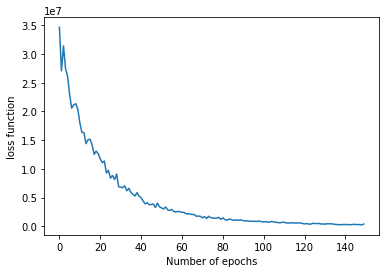

In [7]:
import numpy as np
loss=np.array(loss)
plt.plot(loss)
plt.xlabel('Number of epochs')
plt.ylabel('loss function')
plt .show()

## restore the graph  and run inference 

In [7]:
# with tf.Session() as sess:
#     new_saver = tf.train.import_meta_graph('/home/ppatnaik/pradosa/trained_models/Trained_model_fruit/my-fruit-model-150.meta')
#     new_saver.restore(sess, '/home/ppatnaik/pradosa/trained_models/Trained_model_fruit/my-fruit-model-150')
#     writer=tf.summary.FileWriter('/home/ppatnaik/pradosa/trained_models/Trained_model_fruit')
#     writer.add_graph(sess.graph)
# writer=tf.summary.FileWriter('/home/ppatnaik/pradosa/3')
# writer.add_graph(sess.graph)

INFO:tensorflow:Restoring parameters from /home/ppatnaik/pradosa/trained_models/Trained_model_fruit/my-fruit-model-150


## Evaluate acuuracy

In [10]:
accu=sess.run([accuracy], feed_dict={x: epoch_x, y: epoch_y,keep_prob:1})
accu

[0.98514849]

In [148]:
import pywt as pw
from PIL import Image as im
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from resizeimage import resizeimage
import cv2
import tensorflow as tf
###########################################################################
def getImageWtihOpenCV(path):
    images = []
    count=0
    for img in glob.glob(path):
        count=count+1
        imgs = cv2.imread(img,1)
        if imgs is not None:
            images.append(imgs)
        else:                  
            print (count)       
    return images    

def resize_images_cv2(images,dimension1,dimension2):
    resized_image=[]
    for image in images:
        resized_image.append(cv2.resize(image, (dimension1, dimension2)) )
    return resized_image 

#############################################################################
# provide path to the parent directory 
training_path="/home/ppatnaik/fruit_photos/"
dir_names=os.listdir(training_path)
images=[]
for dir_name in dir_names:
    images.append(np.array(getImageWtihOpenCV(training_path+dir_name+'/*')))
    
images=np.array(images)
training_imags=np.concatenate(images,axis=0)
resized_images=resize_images_cv2(training_imags,50,50) 
img_data=np.array(resized_images)
feature_data=[]
for data in img_data:
    feature_data.append(data.flatten())  
feature_data=np.array(feature_data)

print (feature_data.shape)

(809, 7500)


In [9]:
feature_data=np.array(feature_data).astype(float)


In [10]:
fc_features = sess.run(fc, feed_dict={x: feature_data,keep_prob:0.5})

In [11]:
fc_features.shape

(3000, 1024)

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

PATH = os.getcwd()
LOG_DIR = PATH+ '/flowerEmbedding'
data_path = '/home/ppatnaik' + '/flower_photo2'
data_dir_list = os.listdir(data_path)

print(data_dir_list)

feature_vectors = fc_features
print ("feature_vectors_shape:",feature_vectors.shape)
print ("num of images:",feature_vectors.shape[0])
print ("size of individual feature vector:",feature_vectors.shape[1])

num_of_samples=feature_vectors.shape[0]
num_of_samples_each_class = 100

features = tf.Variable(feature_vectors, name='features')

y1 = np.ones((num_of_samples,),dtype='int64')

y1[0:1000]=0
y1[1000:2000]=1
y1[2000:]=2

names = ['Dahlia','Rose','Tulip']
################################################################################################################################

def images_to_sprite(data):
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)
        # Inverting the colors seems to look better for MNIST
        #data = 1 - data

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
                (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
                constant_values=0)
        # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
                + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data
#%%
sprite = images_to_sprite(img_data)
print(cv2.imwrite(os.path.join(LOG_DIR, 'sprite_4_classes.png'), sprite))
################################################################################################################################
metadata_file = open(os.path.join(LOG_DIR, 'metadata_4_classes.tsv'), 'w')
metadata_file.write('Class\tName\n')
k=100 # num of samples in each class
j=0
#for i in range(210):
#    metadata_file.write('%06d\t%s\n' % (i, names[y[i]]))
for i in range(num_of_samples):
    c = names[y1[i]]
    metadata_file.write('{}\t{}\n'.format(y1[i],c))
    #metadata_file.write('%06d\t%s\n' % (j, c))
metadata_file.close()
print('metadata file written successfully\n')


['Dahlia', 'Rose', 'Tulip']
feature_vectors_shape: (3000, 1024)
num of images: 3000
size of individual feature vector: 1024
True
metadata file written successfully



In [13]:
with tf.Session() as sess:
    saver = tf.train.Saver([features])

    sess.run(features.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'images_4_classes.ckpt'))
    
    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = features.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = os.path.join(LOG_DIR, 'metadata_4_classes.tsv')
    # Comment out if you don't want sprites
    embedding.sprite.image_path = os.path.join(LOG_DIR, 'sprite_4_classes.png')
#     embedding.sprite.image_path=os.path.join('/home/ppatnaik/pradosa/embedding-logExp1','sprite_4_classes.png')
    embedding.sprite.single_image_dim.extend([img_data.shape[1], img_data.shape[1]])
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)

## Visaulize the weights in the convilutional layer

In [18]:
temp_weights = sess.run(weights, feed_dict={x:input_data[0], y:input_data[1]})

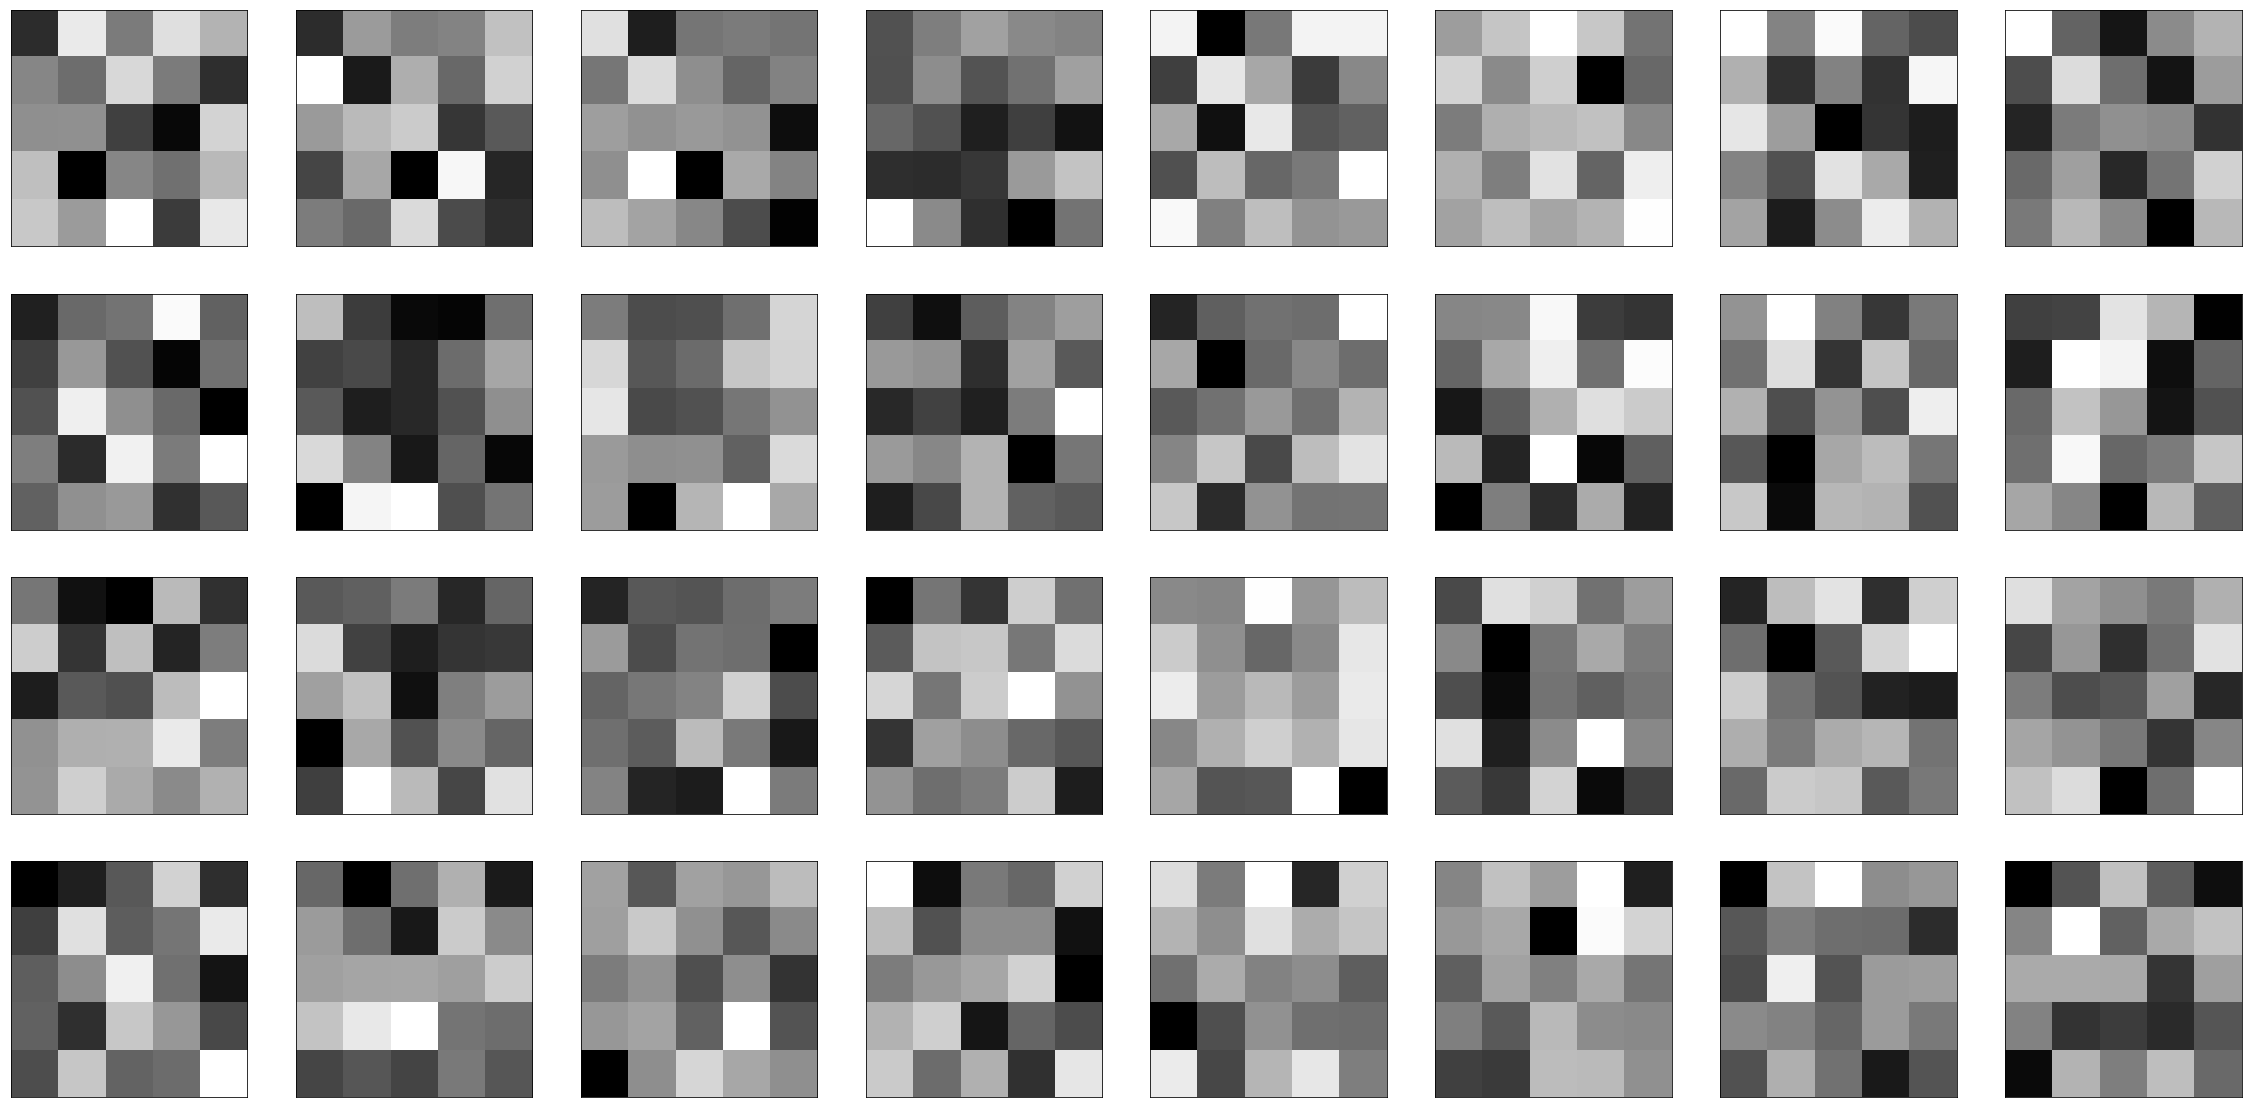

In [19]:
fig = plt.figure(figsize=(40, 20))
for i in range(32):
    ax=fig.add_subplot(4,32/4, i+1)
    w=temp_weights['W_conv1'][:,:,:,i][:,:,0]
    plt.imshow(w, interpolation='nearest',cmap=plt.get_cmap('gray'))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)   
plt.show()    

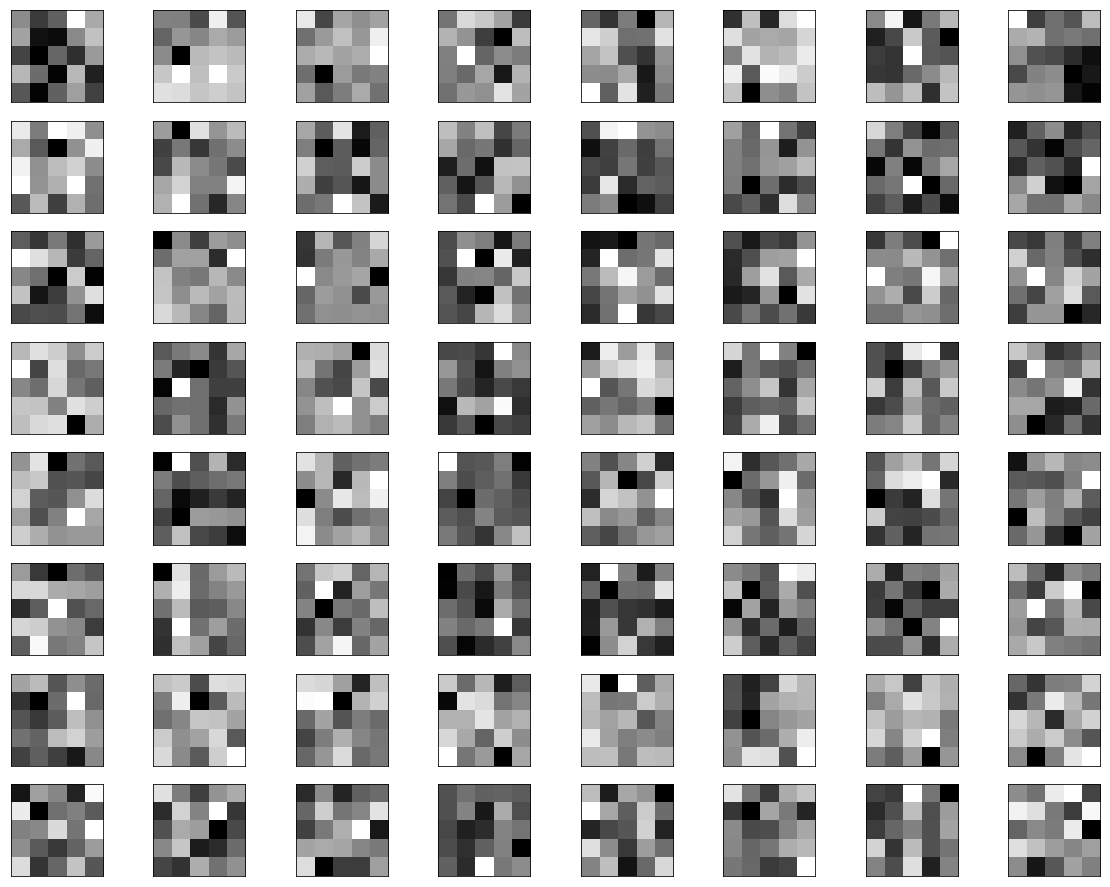

In [20]:
fig = plt.figure(figsize=(20, 20))
for i in range(64):
    ax=fig.add_subplot(10,32/4, i+1)
    w=temp_weights['W_conv2'][:,:,:,i][:,:,0]
    plt.imshow(w, interpolation='nearest',cmap=plt.get_cmap('gray'))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)   
plt.show() 

## Visualize the output of each convlayer

In [23]:
temp_conv1 = sess.run(conv1, feed_dict={x:input_data[0], y:input_data[1]})

In [84]:
temp_conv1.shape

(808, 25, 25, 32)

In [24]:
p=temp_conv1[0,:,:,2]
p.shape

(25, 25)

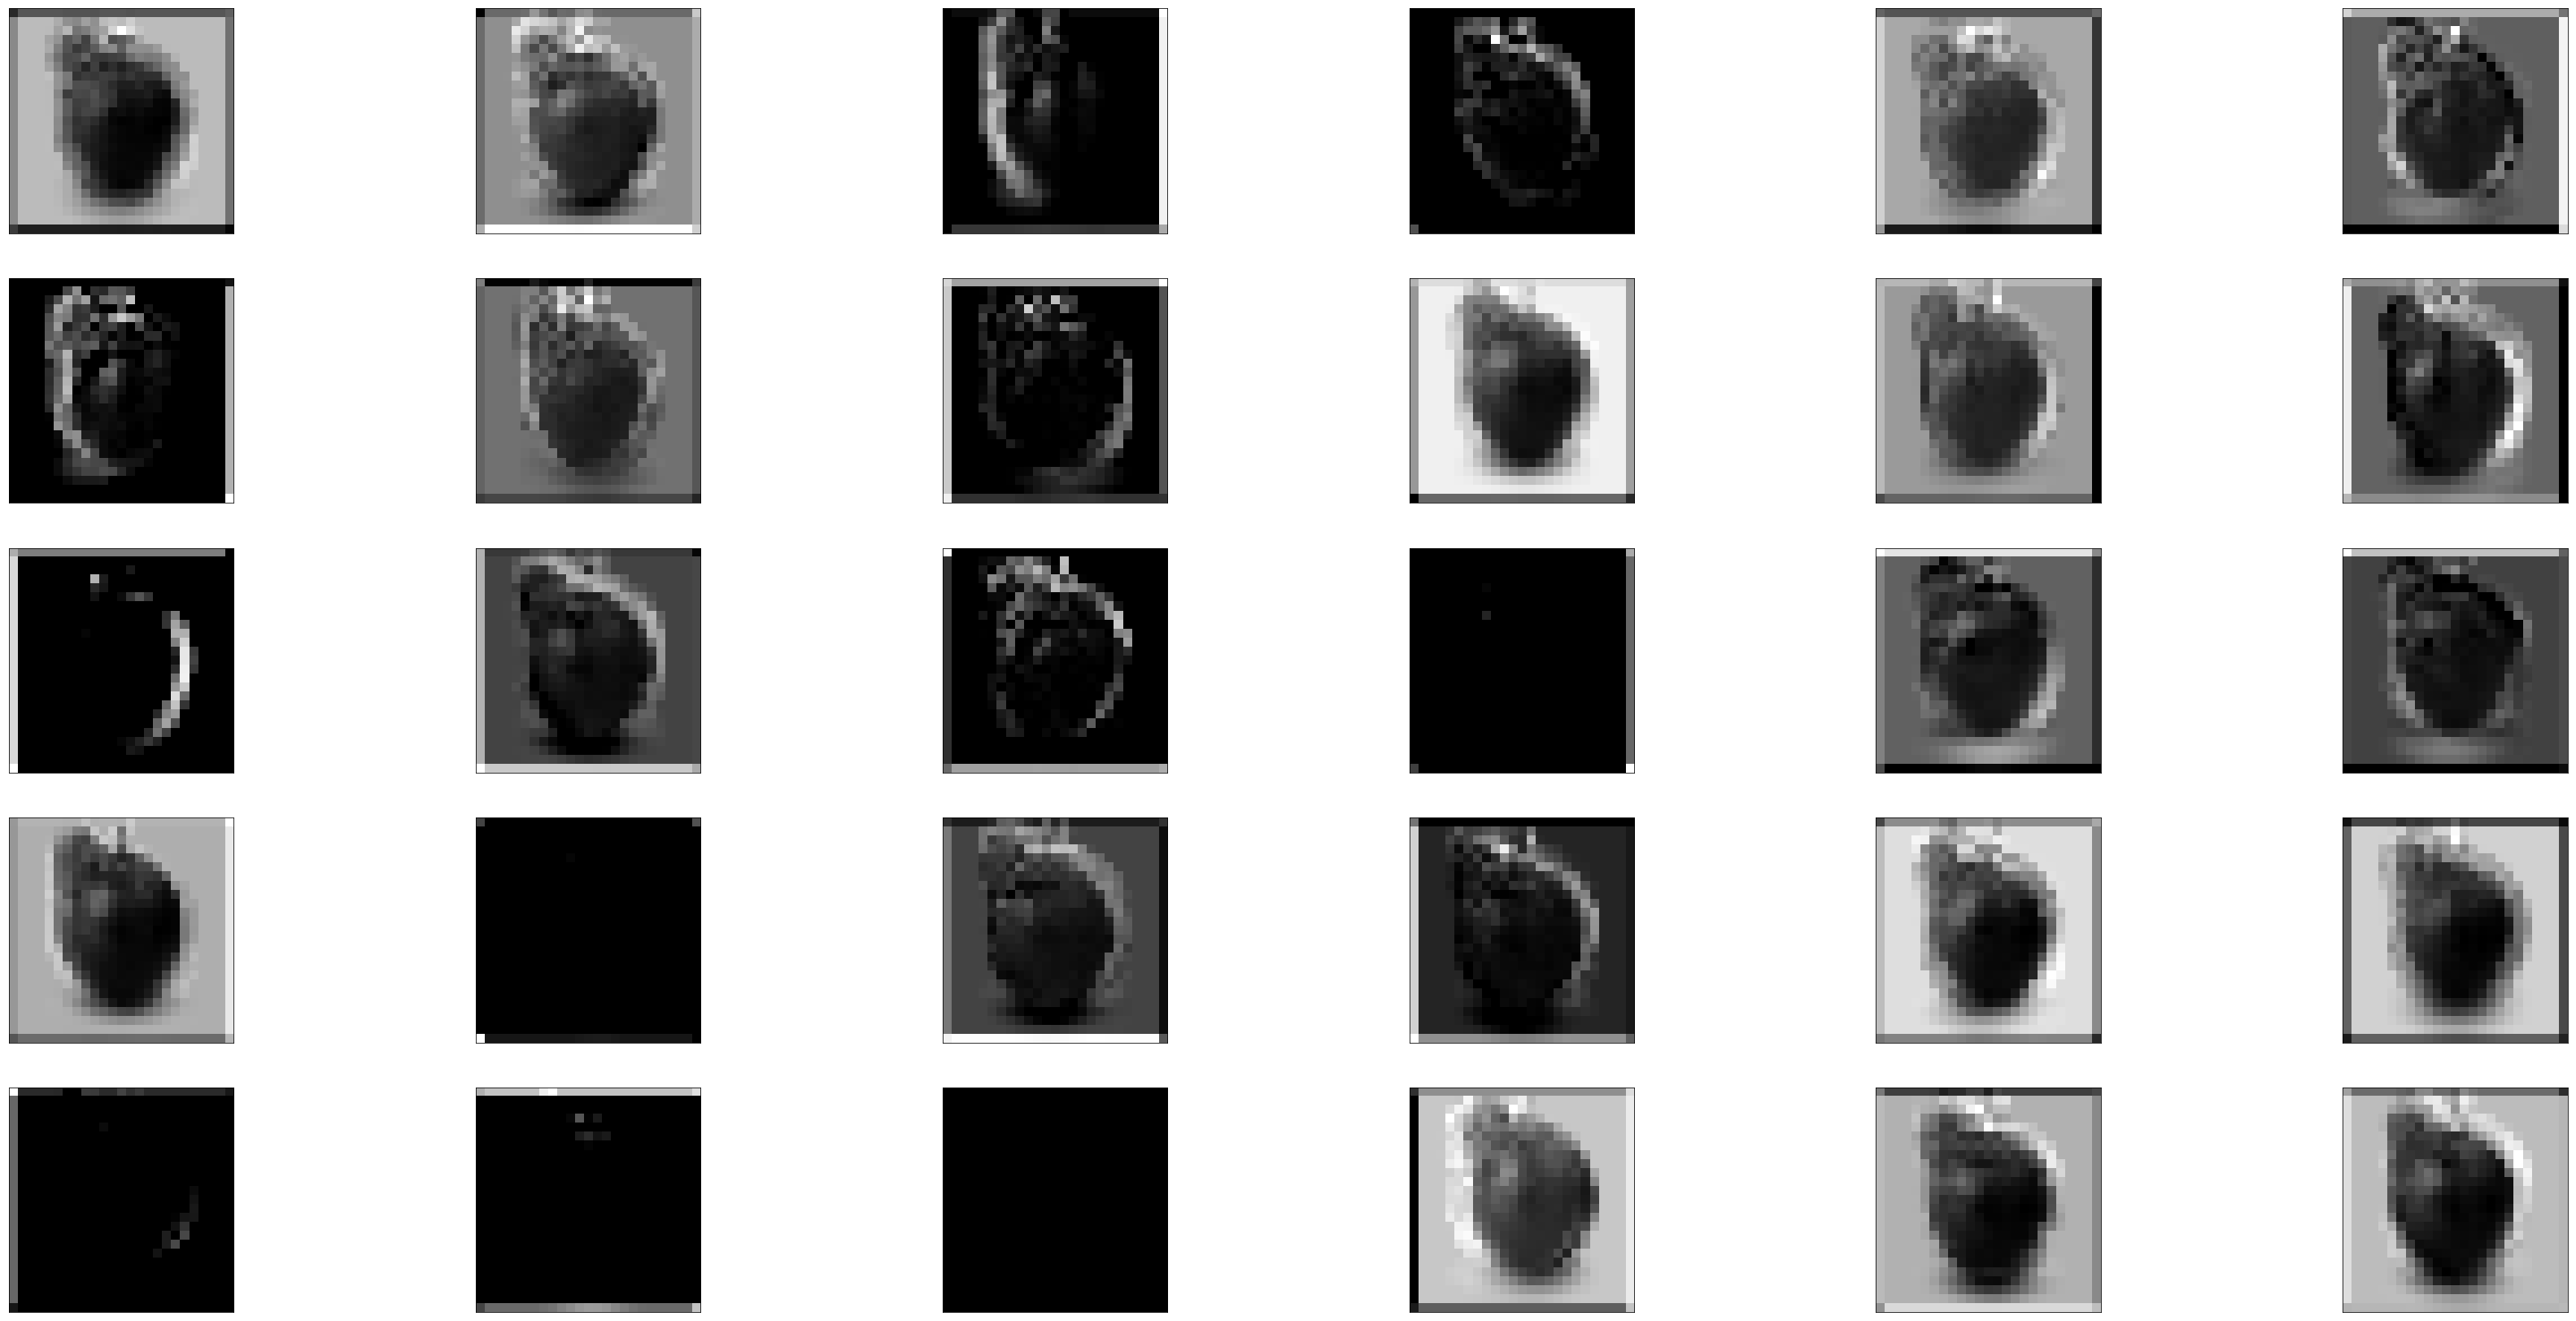

In [123]:
fig = plt.figure(figsize=(60, 60))
for i in range(30):
    ax=fig.add_subplot(10,32/5, i+1)
    p=temp_conv1[0,:,:,i]
    plt.imshow(p, interpolation='nearest',cmap=plt.get_cmap('gray'))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)   
plt.show() 

In [26]:
temp_conv2 = sess.run(conv2, feed_dict={conv1:temp_conv1})

In [33]:
q=temp_conv2[0,:,:,2]
q.shape

(13, 13)

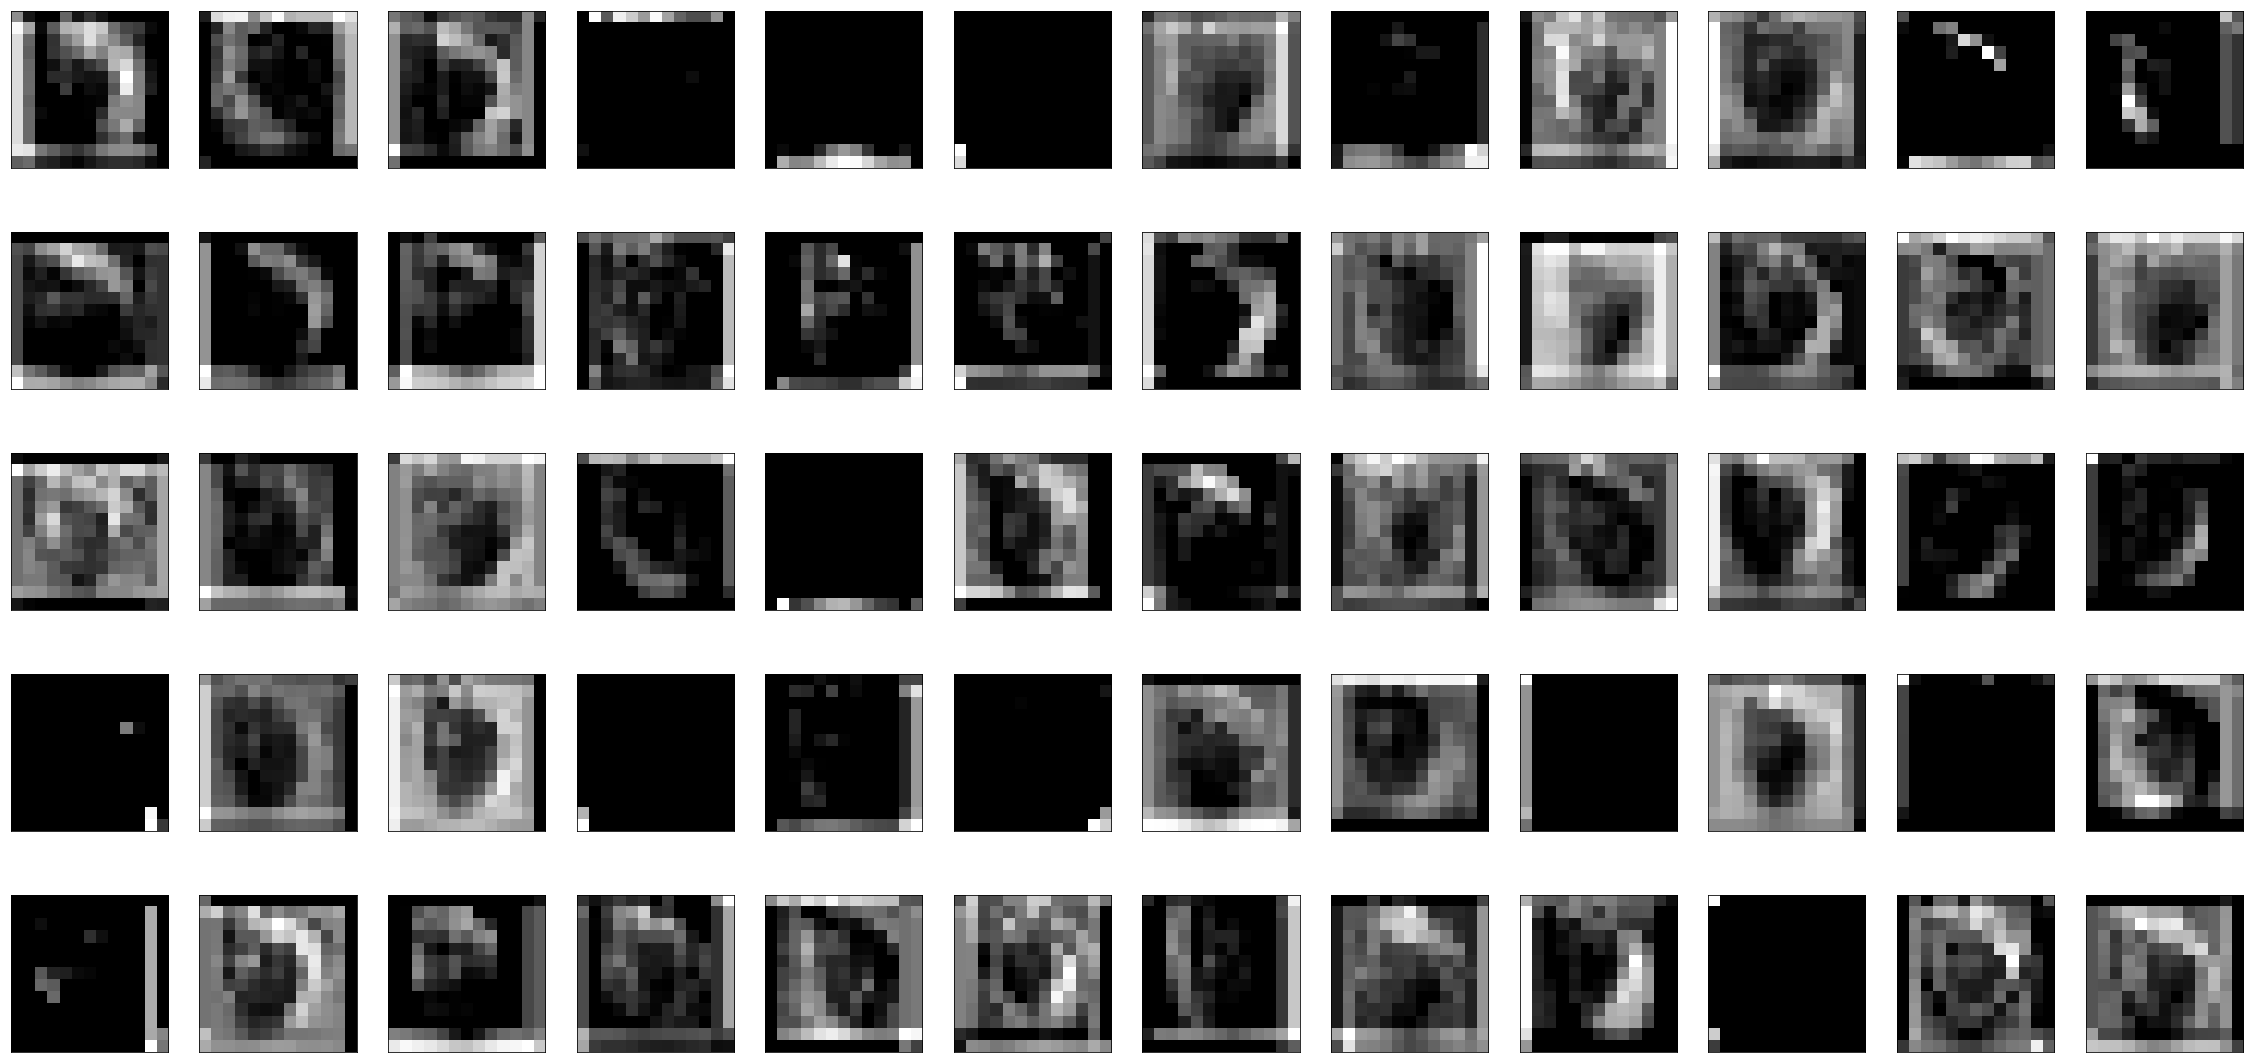

In [27]:
fig = plt.figure(figsize=(40, 40))
for i in range(60):
    ax=fig.add_subplot(10,64/5, i+1)
    p=temp_conv2[0,:,:,i]
    plt.imshow(p, interpolation='nearest',cmap=plt.get_cmap('gray'))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)   
plt.show()

## Tensorboard embeddings

In [171]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

In [40]:
tf.__version__

'1.1.0'

In [172]:
PATH = os.getcwd()
LOG_DIR = PATH+ '/newembedding'
data_path = PATH + '/Fruit_training'
data_dir_list = os.listdir(data_path)

In [174]:
LOG_DIR

'/home/ppatnaik/pradosa/newembedding'

In [175]:
def getImageWtihOpenCV(path):
    images = []
    count=0
    for img in glob.glob(path):
        count=count+1
        imgs = cv2.imread(img,1)
        if imgs is not None:
            images.append(imgs)
        else:                  
            print (count)       
    return images    

def resize_images_cv2(images,dimension1,dimension2):
    resized_image=[]
    for image in images:
        resized_image.append(cv2.resize(image, (dimension1, dimension2)) )
    return resized_image 

In [176]:
images1=getImageWtihOpenCV(data_path+'/*')
images=resize_images_cv2(images1,200,200)
img_data=np.array(images)

65
98


In [1]:
feature_vectors = feature_data
print ("feature_vectors_shape:",feature_vectors.shape)
print ("num of images:",feature_vectors.shape[0])
print ("size of individual feature vector:",feature_vectors.shape[1])

num_of_samples=feature_vectors.shape[0]
num_of_samples_each_class = 100

features = tf.Variable(feature_vectors, name='features')

y1 = np.ones((num_of_samples,),dtype='int64')

y1[0:302]=0
y1[302:558]=1
y1[558:]=2

names = ['apple','orange','strawberry']

NameError: name 'feature_data' is not defined

In [178]:

# Taken from: https://github.com/tensorflow/tensorflow/issues/6322
def images_to_sprite(data):
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)
        # Inverting the colors seems to look better for MNIST
        #data = 1 - data

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
                (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
                constant_values=0)
        # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
                + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data
#%%
sprite = images_to_sprite(img_data)
#cv2.imwrite(os.path.join(LOG_DIR, 'sprite_4_classes.png'), sprite)

In [179]:
cv2.imwrite(os.path.join(LOG_DIR, 'sprite_4_classes.png'), sprite)

True

In [180]:
metadata_file = open(os.path.join(LOG_DIR, 'metadata_4_classes.tsv'), 'w')
metadata_file.write('Class\tName\n')
k=100 # num of samples in each class
j=0
#for i in range(210):
#    metadata_file.write('%06d\t%s\n' % (i, names[y[i]]))
for i in range(num_of_samples):
    c = names[y1[i]]
    metadata_file.write('{}\t{}\n'.format(y1[i],c))
    #metadata_file.write('%06d\t%s\n' % (j, c))
metadata_file.close()


In [159]:
features

<tf.Variable 'features_1:0' shape=(808, 3) dtype=float32_ref>

In [181]:
with tf.Session() as sess:
    saver = tf.train.Saver([features])

    sess.run(features.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'images_4_classes.ckpt'))
    
    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = features.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = os.path.join(LOG_DIR, 'metadata_4_classes.tsv')
    # Comment out if you don't want sprites
    embedding.sprite.image_path = os.path.join(LOG_DIR, 'sprite_4_classes.png')
#     embedding.sprite.image_path=os.path.join('/home/ppatnaik/pradosa/embedding-logExp1','sprite_4_classes.png')
    embedding.sprite.single_image_dim.extend([img_data.shape[1], img_data.shape[1]])
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)

## Function to train the network

In [ ]:
def train_neural_network(x):
    prediction,conv1,conv2 = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y) )
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    hm_epochs = 1
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(hm_epochs):
            epoch_loss = 0
            for _ in range(int(mnist.train.num_examples/batch_size)):
                epoch_x, epoch_y = mnist.train.next_batch(batch_size)
                _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
                epoch_loss += c

            print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)

        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print('Accuracy:',accuracy.eval({x:mnist.test.images, y:mnist.test.labels}))

In [25]:
training_path="/home/ppatnaik/flower_photo2/"
dir_names=os.listdir(training_path)
images=[]
for dir_name in dir_names:
    images.append(np.array(getImageWtihOpenCV(training_path+dir_name+'/*')))
    
images=np.array(images)
training_imags=np.concatenate(images,axis=0)
resized_images=resize_images_cv2(training_imags,50,50) 
img_data=np.array(resized_images)
feature_data=[]
for data in img_data:
    feature_data.append(data.flatten())  
feature_data=np.array(feature_data)

print (feature_data.shape)

(3000, 2500)


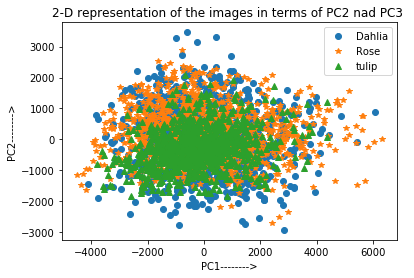

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3).fit(feature_data)
pca_2d = pca.transform(feature_data)
ds1 = pca_2d[0:1000]
ds2 = pca_2d[1000:2000]
ds3 = pca_2d[2000:]
%matplotlib inline
plt.plot(ds1[:,0],ds1[:,1],'o',label='Dahlia')
plt.plot(ds2[:,0],ds2[:,1],'*',label='Rose')
plt.plot(ds3[:,0],ds3[:,1],'^',label='tulip')
plt.xlabel('PC1-------->')
plt.ylabel('PC2-------->')
    # plot the centroids
    #lines = plt.plot(centroids[i,0],centroids[i,1],'kx')
#     # make the centroid x's bigger
#     plt.setp(lines,ms=15.0)
#     plt.setp(lines,mew=2.0)
plt.legend()
plt.title('2-D representation of the images in terms of PC2 nad PC3 ')
# plt.plot(pca_2d.mean(axis=0),'*',color='b')    
plt.show()

## Read features from the bottlenecks extracted from InceptionV3

In [122]:
list_sub_dir = os.listdir('/tmp/bottleneck/')
bottle_necklist = []
ground_truth=[]
for sub_dir in list_sub_dir:
    sub_dir_path = os.path.join('/tmp/bottleneck/', sub_dir)
    bottleneck_path=sub_dir_path+'/*'
    print(sub_dir_path)
    for bottleneck_file in glob.glob(bottleneck_path):
        with open(bottleneck_file, 'r') as bottleneck_file1:
            bottleneck_string = bottleneck_file1.read()
        did_hit_error = False
        try:
            bottleneck_values = [float(x) for x in bottleneck_string.split(',')]
            bottle_necklist.append(bottleneck_values)
            if sub_dir==list_sub_dir[0]:
                ground_truth.append(0)
            elif sub_dir==list_sub_dir[1]:   
                ground_truth.append(1)
            else:
                 ground_truth.append(2)
        except ValueError:
            tf.logging.warning('Invalid float found, recreating bottleneck')
        did_hit_error = True


/tmp/bottleneck/strawberry
/tmp/bottleneck/apple
/tmp/bottleneck/orange


In [ ]:
ground_truth[2000:3000]

In [123]:
len(bottle_necklist)
bottle_neckFeatures=np.array(bottle_necklist)

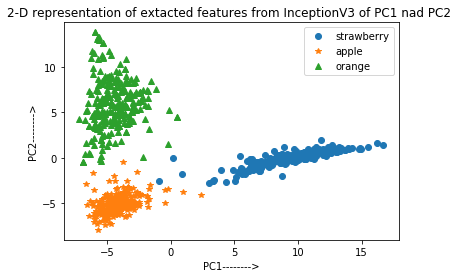

In [162]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3).fit(bottle_neckFeatures)
pca_2d = pca.transform(bottle_neckFeatures)
ds1 = pca_2d[0:255]
ds2 = pca_2d[255:553]
ds3 = pca_2d[553:]
%matplotlib inline
plt.plot(ds1[:,0],ds1[:,1],'o',label='strawberry')
plt.plot(ds2[:,0],ds2[:,1],'*',label='apple')
plt.plot(ds3[:,0],ds3[:,1],'^',label='orange')
plt.xlabel('PC1-------->')
plt.ylabel('PC2-------->')
    # plot the centroids
    #lines = plt.plot(centroids[i,0],centroids[i,1],'kx')
#     # make the centroid x's bigger
#     plt.setp(lines,ms=15.0)
#     plt.setp(lines,mew=2.0)
plt.legend()
plt.title('2-D representation of extacted features from InceptionV3 of PC1 nad PC2 ')
# plt.plot(pca_2d.mean(axis=0),'*',color='b')    
plt.show()


## Affinity propagation

In [178]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
af = AffinityPropagation(damping=0.99,max_iter=30,convergence_iter=100,preference=-250).fit(bottle_neckFeatures)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_                                                                                                                  
n_clusters_ = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 3


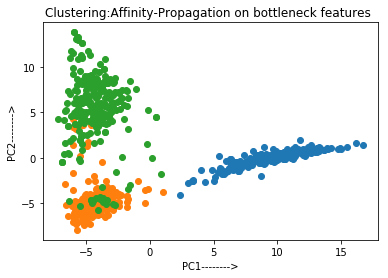

In [182]:
for i in range(len(cluster_centers_indices)):
    # select only data observations with cluster label == i
    ds = pca_2d[np.where(labels==i)]
    # plot the data observations
    plt.plot(ds[:,0],ds[:,1],'o')
    # plot the centroids
    #lines = plt.plot(centroids[i,0],centroids[i,1],'kx')
#     # make the centroid x's bigger
#     plt.setp(lines,ms=15.0)
#     plt.setp(lines,mew=2.0)
    plt.xlabel('PC1-------->')
    plt.ylabel('PC2-------->')
    plt.title('Clustering:Affinity-Propagation on bottleneck features ')  
plt.show()

In [149]:
c0=[]
c1=[]
c2=[]

for i in range(len(labels)):
    if(labels[i]==0):
        c0.append(feature_data[i])
    elif(labels[i]==1):
        c1.append(feature_data[i])
    elif(labels[i]==2):
        c2.append(feature_data[i])
print(len(c0),len(c1),len(c2))  


77 47 43


## Spectal clustering

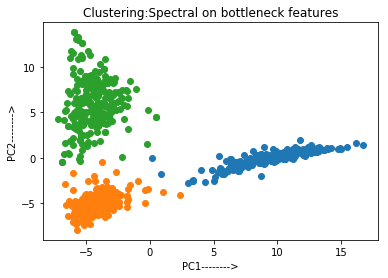

In [189]:
from sklearn.cluster import SpectralClustering
spectral =SpectralClustering(n_clusters=3, eigen_solver='arpack',affinity="nearest_neighbors").fit(bottle_neckFeatures)
labels2=spectral.labels_
for i in range(len(cluster_centers_indices)):
    # select only data observations with cluster label == i
    ds = pca_2d[np.where(labels2==i)]
    # plot the data observations
    plt.plot(ds[:,0],ds[:,1],'o')
    # plot the centroids
    #lines = plt.plot(centroids[i,0],centroids[i,1],'kx')
#     # make the centroid x's bigger
#     plt.setp(lines,ms=15.0)
#     plt.setp(lines,mew=2.0)
    plt.xlabel('PC1-------->')
    plt.ylabel('PC2-------->')
    plt.title('Clustering:Spectral on bottleneck features')
   
plt.show()

## K-means 

In [129]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(bottle_neckFeatures)
labels1=kmeans.labels_
cluster_centers_indices=kmeans.cluster_centers_


In [ ]:
labels1[2000:3000]

In [ ]:
labels1[0:1000]

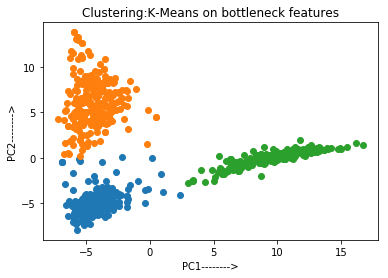

In [183]:
for i in range(len(cluster_centers_indices)):
    # select only data observations with cluster label == i
    ds = pca_2d[np.where(labels1==i)]
    # plot the data observations
    plt.plot(ds[:,0],ds[:,1],'o')
    # plot the centroids
    #lines = plt.plot(centroids[i,0],centroids[i,1],'kx')
#     # make the centroid x's bigger
#     plt.setp(lines,ms=15.0)
#     plt.setp(lines,mew=2.0)
    plt.xlabel('PC1-------->')
    plt.ylabel('PC2-------->')
    plt.title('Clustering:K-Means on bottleneck features')  
plt.show()

In [150]:
c0=[]
c1=[]
c2=[]

for i in range(len(labels1)):
    if(labels1[i]==0):
        c0.append(feature_data[i])
    elif(labels1[i]==1):
        c1.append(feature_data[i])
    elif(labels1[i]==2):
        c2.append(feature_data[i])
  

In [185]:
len(c2)

252

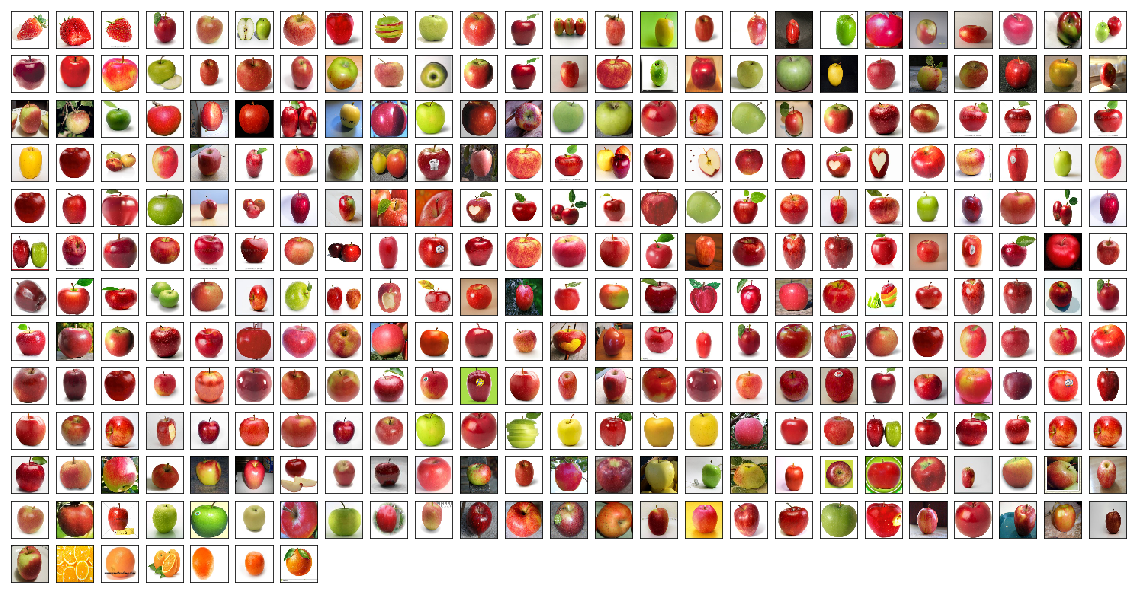

In [158]:

fig = plt.figure(figsize=(20, 90))
for i in range(len(c0)):
    ax=fig.add_subplot(110, 25, i+1)
#     plt.imshow(np.reshape(c0[i],(50,50,3)), interpolation='nearest',cmap=plt.get_cmap('gray'))
    plt.imshow(cv2.cvtColor(np.reshape(c0[i],(50,50,3)), cv2.COLOR_BGR2RGB))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)   
plt.show()

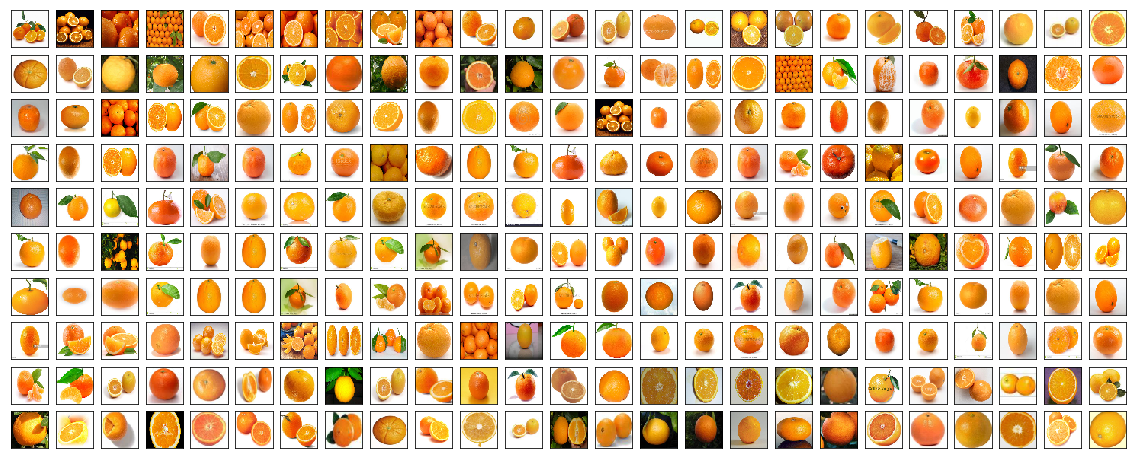

In [160]:
fig = plt.figure(figsize=(20, 90))
for i in range(len(c1)):
    ax=fig.add_subplot(110, 25, i+1)
    plt.imshow(cv2.cvtColor(np.reshape(c1[i],(50,50,3)), cv2.COLOR_BGR2RGB))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)   
plt.show()

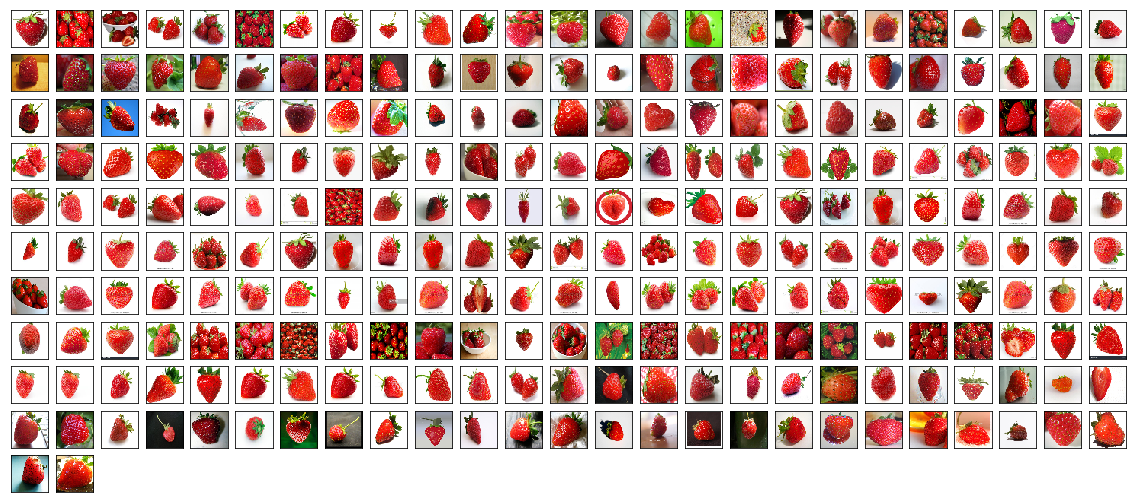

In [161]:
fig = plt.figure(figsize=(20, 90))
for i in range(len(c2)):
    ax=fig.add_subplot(110, 25, i+1)
    plt.imshow(cv2.cvtColor(np.reshape(c2[i],(50,50,3)), cv2.COLOR_BGR2RGB))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)   
plt.show()

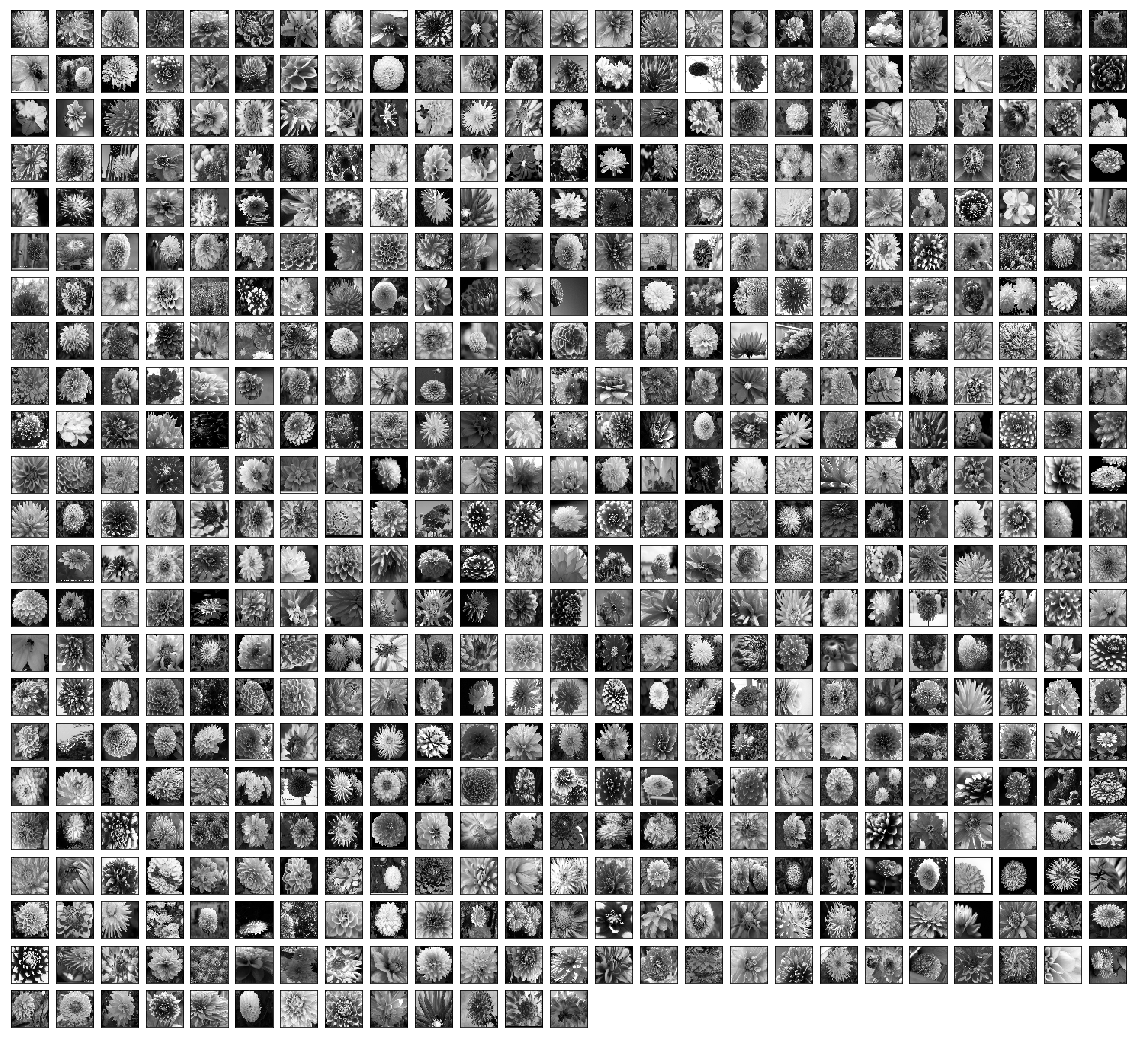

In [77]:
fig = plt.figure(figsize=(20, 90))
for i in range(len(c2)):
    ax=fig.add_subplot(110, 25, i+1)
    plt.imshow(np.reshape(c1[i],(50,50)), interpolation='nearest',cmap=plt.get_cmap('gray'))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)   
plt.show()

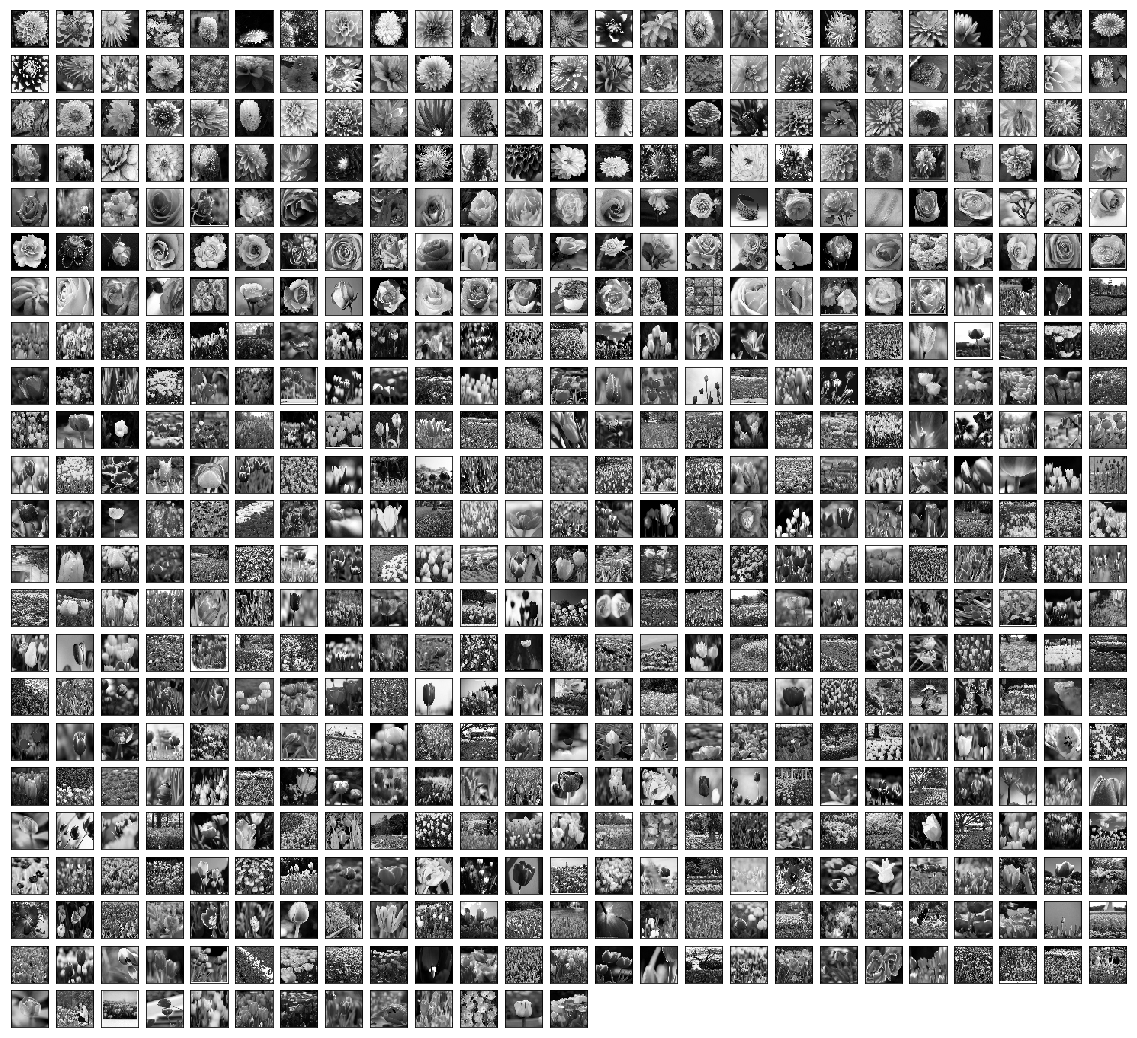

In [78]:
fig = plt.figure(figsize=(20, 90))
for i in range(len(c2)):
    ax=fig.add_subplot(110, 25, i+1)
    plt.imshow(np.reshape(c1[i+500],(50,50)), interpolation='nearest',cmap=plt.get_cmap('gray'))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)   
plt.show()

In [57]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

PATH = os.getcwd()
LOG_DIR = PATH+ '/flowerEmbedding'
data_path = '/home/ppatnaik' + '/flower_photo2'
data_dir_list = os.listdir(data_path)

print(data_dir_list)

feature_vectors = bottle_neckFeatures
print ("feature_vectors_shape:",feature_vectors.shape)
print ("num of images:",feature_vectors.shape[0])
print ("size of individual feature vector:",feature_vectors.shape[1])

num_of_samples=feature_vectors.shape[0]
num_of_samples_each_class = 100

features = tf.Variable(feature_vectors, name='features')

y1 = np.ones((num_of_samples,),dtype='int64')

y1[0:1000]=0
y1[1000:2000]=1
y1[2000:]=2

names = ['Dahlia','Rose','Tulip']
################################################################################################################################

def images_to_sprite(data):
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)
        # Inverting the colors seems to look better for MNIST
        #data = 1 - data

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
                (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
                constant_values=0)
        # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
                + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data
#%%
sprite = images_to_sprite(img_data)
print(cv2.imwrite(os.path.join(LOG_DIR, 'sprite_4_classes.png'), sprite))
################################################################################################################################
metadata_file = open(os.path.join(LOG_DIR, 'metadata_4_classes.tsv'), 'w')
metadata_file.write('Class\tName\n')
k=100 # num of samples in each class
j=0
#for i in range(210):
#    metadata_file.write('%06d\t%s\n' % (i, names[y[i]]))
for i in range(num_of_samples):
    c = names[y1[i]]
    metadata_file.write('{}\t{}\n'.format(y1[i],c))
    #metadata_file.write('%06d\t%s\n' % (j, c))
metadata_file.close()
print('metadata file written successfully\n')


['Dahlia', 'Rose', 'Tulip']
feature_vectors_shape: (3000, 2048)
num of images: 3000
size of individual feature vector: 2048
True
metadata file written successfully



In [58]:
with tf.Session() as sess:
    saver = tf.train.Saver([features])

    sess.run(features.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'images_4_classes.ckpt'))
    
    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = features.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = os.path.join(LOG_DIR, 'metadata_4_classes.tsv')
    # Comment out if you don't want sprites
    embedding.sprite.image_path = os.path.join(LOG_DIR, 'sprite_4_classes.png')
#     embedding.sprite.image_path=os.path.join('/home/ppatnaik/pradosa/embedding-logExp1','sprite_4_classes.png')
    embedding.sprite.single_image_dim.extend([img_data.shape[1], img_data.shape[1]])
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)
  